# Overview

This is my solution from the course project of IBM [Deep Learning and Reinforcement Learning](https://pt.coursera.org/learn/deep-learning-reinforcement-learning) course. Since it's my first contact with Deep Learning, I chose to use the same dataset from the instructor (but with different analysis) wich is the [Pima Indians Diabetes Database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database) retrieved from Kaggle.

Here the main objective is: **build a neural network with Keras package to predict whether or not the patients in the dataset have diabetes  and compare the performance with an baseline model**.

The dataset was composed by 768 pacients and 9 characteristics from them wich are:
- Number of times pregnant
- Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- Diastolic blood pressure (mm Hg)
- Triceps skin fold thickness (mm)
- 2-Hour serum insulin (mu U/ml)
- Body mass index (weight in kg/(height in m)^2)
- Diabetes pedigree function
- Age (years)
- Class variable (0 or 1)

# Necessary packages

In [2]:
#core
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

#Auto EDA -- !pip install dataprep -- 
#from dataprep.eda import create_report

from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

# Glimpse on Data

In [3]:
PATH = "../data/"

In [4]:
#loading dataframe
df_raw = pd.read_csv(PATH+"diabetes.csv")

#create a copy to avoid edit raw data 
df = df_raw.copy()

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


- There are no missing value
- All features are numerical so they don't need encode

I always like to start the analysis with an auto EDA tool to give a first look on data and and get quick insights. Here I use [dataprep](https://dataprep.ai/) for this purpose.

In [ ]:
#this code export a html file named diabetes_job.html with dataprep output which can be opened locally by any browser 
report = create_report(df, title='Diabetes Prediction')
report.save("diabetes_job.html")

Report has been saved to diabetes_job.html!


From the Auto EDA it's possible to note that:
- Glucose, BloodPressure, SkinThickness, Insulin and BMI have 0 values wich is biologically impossible.
- There is a desbalance between the classes, 65.1% from the pacients don't have diabetes meanwhile 34.9% have.

# Fixing Inconsistences

Since the dataset has a relatively small number of observations, drop the rows with 0 value from the collumns cited is inviable. Since the features had some skewness I impute those values with the median.

In [ ]:
inconsistent_features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

def replace_median(feature):
  df[feature] = df[feature].replace(0, df[feature].median())

for i in inconsistent_features:
  replace_median(i)

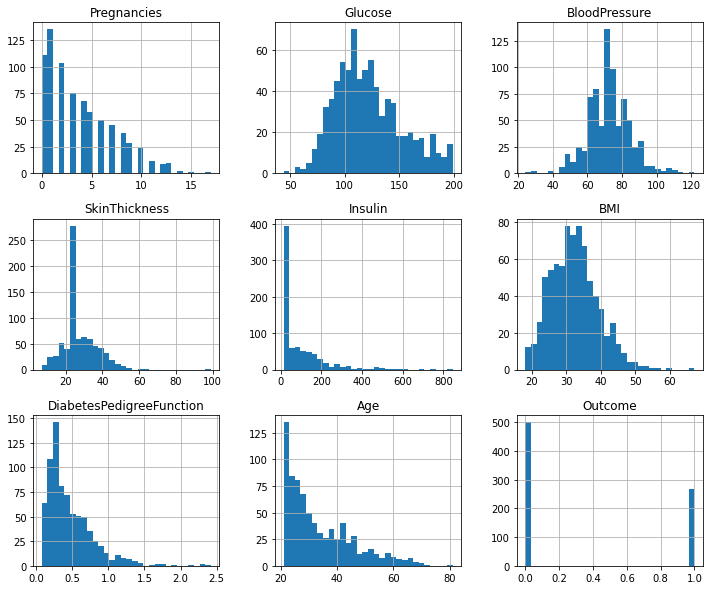

In [ ]:
df.hist(figsize = (12,10), bins = 30);

In [ ]:
df.Insulin.min()

14.0

# Machine Learning

In [ ]:
#Separating X and y features

X = df.drop("Outcome", axis = 1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, test_size = 0.3, stratify = y)

# Making a Baseline

For the baseline I will train a Random Forest. Since it's a tree method don't require any type of scale or normalization.

In [ ]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, n_jobs = -1)

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

In [ ]:
yhat = rf.predict(X_test)

In [ ]:
#accuracy
accuracy_score(y_test, yhat)

0.7489177489177489

In [ ]:
#roc
roc_auc_score(y_test, yhat)

0.7044444444444444

# Build a Single Hidden Layer Neural Network

We need to scale the data to make easier the convergence of Gradient Descendent from network

In [ ]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train) 
X_test_scale = scaler.transform(X_test)

In [ ]:
# The input had 8 features, so the input_shape is (8,). The model had 1 hidden layer, 12 hidden nodes and sigmoid activation.
# Final layer has just one node with a sigmoid activation

model_1 = Sequential()
model_1.add(Dense(12,input_shape = (8,),activation = 'sigmoid'))
model_1.add(Dense(1,activation='sigmoid'))

model_1.compile(SGD(learning_rate = .003), "binary_crossentropy")

In [ ]:
yhat = (model_1.predict(X_test_scale) > 0.5).astype("int32")

8/8 [==============================] - 0s 2ms/step


In [ ]:
#accuracy
accuracy_score(y_test, yhat)

0.35064935064935066

In [ ]:
#roc
roc_auc_score(y_test, yhat)

0.5

The Neural Network perform very bad related the Random Forest. This should because NN is "data hungry" and we provied few data to the model.